#Preparation


## Import

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as tt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import gc
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from PIL import Image
%matplotlib inline
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import pandas as pd
from torchvision import models
from torch.nn import functional as F

sns.set(style='darkgrid', font_scale=1.2)
BATCH_SIZE = 32
RESCALE_SIZE = 224

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = 'cpu'
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = 'cuda'

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from torchvision.models import ResNet18_Weights, resnet18, efficientnet_b3, EfficientNet_B3_Weights, ResNet34_Weights, resnet34
res_transform = ResNet18_Weights.IMAGENET1K_V1.transforms
res_34_transform = ResNet34_Weights.IMAGENET1K_V1.transforms


In [ ]:
def evaluate(model, loader):
    matched = 0
    all = 0
    model.eval()
    for i, l in loader:
        pred = model(i.to(DEVICE)).detach().to('cpu').argmax(dim=1)
        matched += (pred == l).sum()
        all += len(l)

    return (matched/all).item()

In [ ]:
def show_im(im):
    im = im.detach().to('cpu').permute(1, 2, 0).numpy()
    # print(im.shape)
    plt.axis('off')
    plt.imshow(im)

## Load data

In [ ]:

!unzip -q "/content/drive/MyDrive/celebA_train_500.zip"

In [ ]:

!unzip -q "/content/drive/MyDrive/celebA_ir.zip"



In [ ]:

anno = pd.read_csv('./celebA_train_500/celebA_anno.txt', sep=" ", header=None, names=['name', 'label'])
train_test_df = pd.read_csv('./celebA_train_500/celebA_train_split.txt', sep=" ", header=None, names=['name', 'group'])
train_test_df.groupby(by='group').count()
train_df, val_df, test_df = train_test_df[train_test_df.group == 0], train_test_df[train_test_df.group == 1], train_test_df[train_test_df.group == 2]
len(train_df), len(val_df), len(test_df)

(8544, 1878, 1589)

In [ ]:

path = Path('./celebA_train_500/celebA_imgs')
path

PosixPath('celebA_train_500/celebA_imgs')

In [ ]:
files = (list(path.rglob('*.jpg')))
files_name = list(map(lambda x: str(x).split('/')[-1], files))
df = pd.DataFrame({'name':files_name, 'file': files})
data = pd.merge(df, anno, on='name')
data


train_data = pd.merge(data, train_df, on='name')
test_data = pd.merge(data, test_df, on='name')
val_data = pd.merge(data, val_df, on='name')



##Dataset

In [ ]:
class FaceDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataframe, mode='test', transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = dataframe
        self.transform = transform


    def __len__(self):
        return len(self.data)

    @classmethod
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    @classmethod
    def prepare_sample(self, image):
        image = np.array(image)
        image = Image.fromarray(image[77:-41, 45:-50])
        # print(image.shape)
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))

        return image

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        file_name = self.data.iloc[idx, 1]
        label = self.data.iloc[idx, 2]
        im = self.load_sample(file_name)
        im = self.prepare_sample(im)
        if self.transform:
            im = self.transform(im)

        # im = torch.FloatTensor(im).permute(2, 0, 1)

        return im, label

In [ ]:
# train_transform = tt.Compose([
#     resTransform(),
#     tt.RandomHorizontalFlip(p=0.5),
# ])

train_transform = tt.Compose([
    # EfficientNet_B3_Weights.IMAGENET1K_V1.transforms(),
    res_transform(),
    tt.RandomHorizontalFlip(p=0.5),
    # tt.RandomPerspective(distortion_scale=0.5, p=0.3,)
])
test_transform = res_transform()

In [ ]:

train_dataset = FaceDataset(train_data, mode='train', transform=train_transform)
val_dataset = FaceDataset(val_data, mode='val', transform=test_transform)
test_dataset = FaceDataset(test_data, mode='test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
len(train_data), len(val_data), len(test_data)


(8544, 1878, 1589)

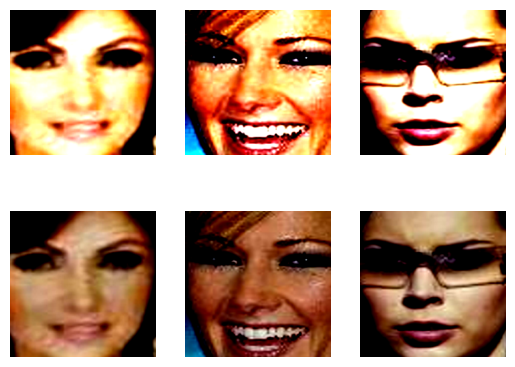

In [ ]:
for i in [1, 2, 3]:
    # print(train_dataset[i][1])
    plt.subplot(2, 3, i)
    show_im(train_dataset[i][0])

    plt.subplot(2, 3, i+3)
    show_im(train_dataset[i][0]/train_dataset[i][0].abs().max())


In [ ]:

sample = 0
for i, v in train_loader:
    sample = i
    break

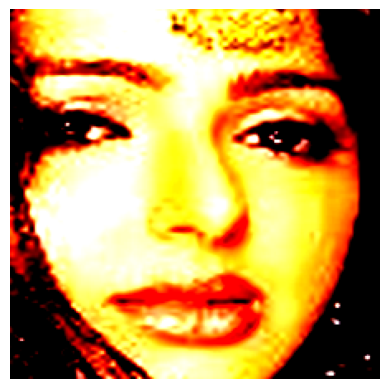

In [ ]:
show_im(sample[0])

In [ ]:
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

##utils

In [ ]:
def clear_cuda():
  torch.cuda.empty_cache()
  torch.cuda.memory_summary(device=None, abbreviated=False)
  # del unet_model

  # del variables
  gc.collect()

In [ ]:
class IdBlock(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return x

In [ ]:
def update_loader(base_transform, pre_transform):
  train_transform = tt.Compose([
      # EfficientNet_B3_Weights.IMAGENET1K_V1.transforms(),
      base_transform,
      *pre_transform
  ])
  test_transform = base_transform

  train_dataset = FaceDataset(train_data, mode='train', transform=train_transform)
  val_dataset = FaceDataset(val_data, mode='val', transform=test_transform)
  test_dataset = FaceDataset(test_data, mode='test', transform=test_transform)

  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

  return train_loader, val_loader, test_loader



In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    model.to(DEVICE)
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [ ]:
def model_device(model_):
    return next(model_.parameters()).device

def freeze_layers(model_, numm=0, optimizer = torch.optim.Adam, lr1=1e-4, lr2=1e-5):
    req_g = False
    threshold = len(list(model_.features.parameters()))
    print(f'{threshold=}')
    for k, (name, module) in enumerate(model_.named_children()):
        if name in ['classifier', 'avgpool']:
            req_g = True
        else:
            req_g = False
        c = 0
        for k, i in enumerate(list(module.parameters())):
            i.requires_grad = (k >= threshold-numm) or req_g
            c += int(i.requires_grad)
    print(count_graded(model_))
    ret = {}
    ret['model'] = model_
    ret['optimizer'] = update_optimizer(model_, numm, optimizer, lr1, lr2)
    return ret.values()

def count_graded(model_):
    d = {}
    for name, mod in model_.named_children():
        d[name] = {True:0, False:0}
        for i in mod.parameters():
            d[name][i.requires_grad] += 1
    return d

def update_optimizer(model_, num, optimizer, lr1, lr2):
    return optimizer(
        params=[
            {"params": model_.classifier.parameters(), 'lr': lr1},
            {"params": list(model_.features.parameters())[-num:], "lr": lr2,}
        ])

def train_w_freezed(model, train_datasset=train_dataset, val_dataset=val_dataset, unfreezed_nm=1, lr_classifier=1e-4, lr_feature=1e-4, loss_fn=nn.CrossEntropyLoss, epochs=5, batch_size=64):
  train_w_freezed.called_times += 1
  model.to(DEVICE)
  model, optimizer = freeze_layers(model, numm = unfreezed_nm, lr1=lr_classifier, lr2=lr_feature)
  history = train(train_dataset, val_dataset, model=model, epochs=epochs, batch_size=batch_size, loss_fn=loss_fn, opt=optimizer)
  # torch.save(model, f'/content/gdrive/MyDrive/finefn{train_w_freezed.called_times}.pth')
  return history

train_w_freezed.called_times = 6

In [ ]:
def fit_epoch_arcane(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    model.to(DEVICE)
    # print(f"{train_loader}")
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        embed = model(inputs)
        loss, outputs = criterion(embed, labels)
        # print(loss.shape)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch_arcane(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            embed = model(inputs)
            loss, outputs = criterion(embed, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

def train_arcane(train_loader, val_loader, model, epochs, batch_size, opt, lr1=1e-4, lr2=1e-4, criterion = nn.CrossEntropyLoss()):
    model.to(DEVICE)
    criterion.to(DEVICE)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"


    with tqdm(desc="epoch", total=epochs) as pbar_outer:


        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch_arcane(model, train_loader, criterion, opt)

            val_loss, val_acc = eval_epoch_arcane(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def update_opt_resnet(model, opt, num, lr):
    params = []
    for name, i in list(model.named_children())[-num:]:
        # print(name)
        params.append({'params': i.parameters(), 'lr': lr})
    # print(params)
    return opt(params)

def freeze_blocks(model, num, blocks, opt=torch.optim.Adam, lr=1e-4):
    req = False
    for name, module in model.named_children():
        if name == blocks[-num]:
            req = True
        for param in module.parameters():
            param.requires_grad = req
        # print(name)
    return update_opt_resnet(model, opt, num, lr)

# opt = freeze_blocks(modelResNet, 3, blocks)
# count_graded(modelResNet)

In [ ]:
def train(train_loader, val_loader, model, epochs, batch_size, opt, lr1=1e-4, lr2=1e-4, criterion = nn.CrossEntropyLoss()):
    model.to(DEVICE)
    criterion.to(DEVICE)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"


    with tqdm(desc="epoch", total=epochs) as pbar_outer:


        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

def train_arcane(train_loader, val_loader, model, epochs, batch_size, opt, lr1=1e-4, lr2=1e-4, criterion = nn.CrossEntropyLoss()):
    model.to(DEVICE)
    criterion.to(DEVICE)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"


    with tqdm(desc="epoch", total=epochs) as pbar_outer:


        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch_arcane(model, train_loader, criterion, opt)

            val_loss, val_acc = eval_epoch_arcane(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

# Resnet -- получилось

Сначала тренируем resnet на обычный CELoss, получаем accuracy 72%

In [ ]:
modelResNet1 = resnet18(ResNet18_Weights.IMAGENET1K_V1)
modelResNet1;

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 316MB/s]


In [ ]:
class IdBlock(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return x

In [ ]:
# modelResNet = resnet18(ResNet18_Weights.IMAGENET1K_V1)
modelResNet = torch.load('/content/drive/MyDrive/DLS project/modelResnet.pth')

In [ ]:
modelResNet.eval()
evaluate(modelResNet, test_loader)

0.7293895483016968

In [ ]:
blocks = [i[0] for i in modelResNet.named_children()]
blocks

In [ ]:
modelResNet.fc = nn.Sequential(
    nn.Linear(512, 512)
    , nn.ReLU()
    , nn.Linear(512, 500)
)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    model.train()

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu().numpy() / processed_size
    return val_loss, val_acc


In [ ]:
# opt = torch.optim.Adam(
#         params=[
#             {"params": modelResNet.layer4.parameters(), 'lr': 1e-4},
#             {"params": modelResNet.fc.parameters(), "lr": 1e-4}
#         ])
hist = train(train_loader, val_loader, modelResNet, epochs=10, batch_size=32, opt=opt)

In [ ]:
loss, acc, val_loss, val_acc = zip(*hist)

In [ ]:
plt.figure(figsize=(15, 9))
plt.subplot(2, 1, 1)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.subplot(2, 1, 2)
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
print(count_graded(modelResNet))
modelResNet.eval()
print(evaluate(modelResNet, test_loader))
print(evaluate(modelResNet, train_loader))

In [ ]:
opt1 = freeze_blocks(modelResNet, 4, blocks)

count_graded(modelResNet)

In [ ]:
hist1 = train(train_loader, val_loader, modelResNet, epochs=10, batch_size=32, opt=opt1)

In [ ]:
opt2 = freeze_blocks(modelResNet, 7, blocks)

count_graded(modelResNet)

hist2 = train(train_loader, val_loader, modelResNet, epochs=10, batch_size=32, opt=opt2)

In [ ]:
opt3 = freeze_blocks(modelResNet, 8, blocks)

count_graded(modelResNet)

hist3 = train(train_loader, val_loader, modelResNet, epochs=5, batch_size=32, opt=opt3)

In [ ]:
opt4 = freeze_blocks(modelResNet, 9, blocks)

count_graded(modelResNet)

hist4 = train(train_loader, val_loader, modelResNet, epochs=5, batch_size=32, opt=opt4)

In [ ]:
opt5 = freeze_blocks(modelResNet, 9, blocks)

count_graded(modelResNet)

hist5 = train(train_loader, val_loader, modelResNet, epochs=10, batch_size=32, opt=opt5)

In [ ]:
train_transform = tt.Compose([
    # EfficientNet_B3_Weights.IMAGENET1K_V1.transforms(),
    res_transform(),
    tt.RandomHorizontalFlip(p=0.5),
    # tt.RandomPerspective(distortion_scale=0.5, p=0.3,)
])
test_transform = res_transform()

In [ ]:

train_dataset = FaceDataset(train_data, mode='train', transform=train_transform)
val_dataset = FaceDataset(val_data, mode='val', transform=test_transform)
test_dataset = FaceDataset(test_data, mode='test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
opt6 = freeze_blocks(modelResNet, 9, blocks)

count_graded(modelResNet)

hist6 = train(train_loader, val_loader, modelResNet, epochs=5, batch_size=32, opt=opt6)

In [ ]:
hist7 = train(train_loader, val_loader, modelResNet, epochs=5, batch_size=32, opt=opt6)

In [ ]:
opt6 = freeze_blocks(modelResNet, 9, blocks, lr=1e-5)

count_graded(modelResNet)

hist6 = train(train_loader, val_loader, modelResNet, epochs=5, batch_size=32, opt=opt6)

In [ ]:
opt6 = freeze_blocks(modelResNet, 8, blocks, lr=1e-5)

count_graded(modelResNet)

hist6 = train(train_loader, val_loader, modelResNet, epochs=5, batch_size=32, opt=opt6)

In [ ]:
# modelResNet = torch.load("./modelResnet.pth")

##accuracy 72

In [ ]:
evaluate(modelResNet, test_loader)

0.7293895483016968

In [ ]:
torch.save(modelResNet, "/content/drive/MyDrive/DLS project/modelResnet.pth")

#ArcFaceLoss -- получилось

Теперь обучаем resnet34 на ArcFaceLoss

In [ ]:
modelResNet1 = resnet34(ResNet34_Weights.IMAGENET1K_V1).to(DEVICE)
modelResNet1;


In [ ]:
class IdBlock(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return x

In [ ]:
modelResNet1.fc = IdBlock()
modelResNet1(sample).shape

In [ ]:
x = torch.randn(size=(4, 32))
nx = torch.norm(x, dim=(1))
print(nx.shape, x.shape)
xn = x/nx[:, None]
print(torch.norm(x, dim=(1)))
print(xn.norm(dim=(1)))
print(xn[0].norm())
l1 = nn.Linear(32, 16, bias=False)
W = 0
for i in l1.parameters():

  W = i
W.shape
l1(x).shape
print(l1)
nw = torch.norm(W, dim=1)
(W@x.T).shape

wn = (W/nw[:, None])
wn[0].shape, wn[0].norm()
xn[0].shape, xn[0].norm()
cos_theta = (xn[0]*wn[0]).sum()
cosineses = (xn@wn.T)
cosineses[0, 0]
xx = x[0]
ww = W[0]
(xx*ww).sum()/xx.norm()/ww.norm()
sinuses = torch.sqrt(1 - torch.pow(cosineses, 2))

In [ ]:
class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, m, scale):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.m = m
        self.scale = scale
        self.cosm = np.cos(m)
        self.sinm = np.sin(m)
        self.W = torch.nn.Parameter(torch.Tensor(embedding_size, num_classes))
        nn.init.xavier_normal_(self.W)

    def forward(self, embeddings, labels):
        cosine = self.fc(embeddings)
        mask = self.onehot(labels)
        cosine_of_target_classes = cosine[mask == 1]
        modified_cosine_of_target_classes = self.transform_true(
            cosine_of_target_classes
        )
        diff = (modified_cosine_of_target_classes - cosine_of_target_classes).unsqueeze(1)
        logits = cosine + (mask * diff)
        logits = self.scale_logits(logits)
        return nn.CrossEntropyLoss()(logits, labels), logits

    def fc(self, embeddings):

        cosine = F.linear(F.normalize(embeddings), F.normalize(self.W.T))
        return cosine

    def onehot(self, labels):

        batch_size = labels.size(0)
        onehot_ = torch.zeros(batch_size, self.num_classes, device=DEVICE)
        onehot_.scatter_(1, labels.unsqueeze(-1), 1)
        return onehot_

    def transform_true(self, cosineses):

        eps = 1e-6
        sinuses = 1.0 - cosineses**2
        return cosineses*self.cosm - sinuses*self.sinm

    def scale_logits(self, logits):

        return logits * self.scale

class ArcModel(nn.Module):
  def __init__(self, model, arcloss):
        super().__init__()
        self.model = model
        self.loss = arcloss

        self.num_of_params = len(list(model.parameters()))

  def forward(self, x):
        emb12 = self.model(sample)
        cos12 = self.loss.fc(emb12)
        logits12 = self.loss.scale_logits(cos12)
        probs = nn.Softmax(dim=1)(logits12)
        return probs
  def freeze_layers(self, ratio, opt, lr=1e-4, lr_loss=1e-5):
        tr = int(ratio*self.num_of_params)
        params = []
        cur = 0
        req = False

        for i in self.model.parameters():
            if cur >= tr:
                i.requires_grad = True
                params.append({'params':i, 'lr':lr})
            else:
                i.requires_grad = False
            cur += 1
        params.append({'params':self.loss.parameters(), 'lr':lr_loss})
        # print(params)
        return opt(params=params)

In [ ]:
# class ArcFaceLossSoftMax(nn.Module):
#   def __init__(self, m:float, s:float)->None:
#     super().__init__()

#     self.m = m
#     self.s = s

#     self.cosm = np.cos(m)
#     self.sinm = np.sin(m)

#   def forward(self, cosineses):
#     sinuses = torch.sqrt(1 - torch.pow(cosineses, 2))
#     cos_tm  = cosineses*self.cosm - sinuses*self.sinm


#     expon = torch.exp(self.s*cosineses)

#     expon_pm = torch.exp(self.s*cos_tm)

#     sum_exp = expon.sum(dim=1)
#     sum_exp_exc = sum_exp[:, None]-expon

#     SM = expon_pm/(expon_pm + sum_exp_exc)

#     return SM

# class ArcFaceLossFC(nn.Module):
#   def __init__(self, in_, out_)->None:
#     super().__init__()

#     self.W = nn.Parameter(torch.randn(size = (out_, in_)))


#   def forward(self, x):
#     nx = torch.norm(x, dim=1)
#     xn = x/nx[:, None]

#     nw = torch.norm(self.W, dim=1)
#     wn = (self.W/nw[:, None])
#     cosineses = (xn@wn.T)
#     return cosineses

# class ArcFaceLossEntropy(nn.Module):
#   def __init__(self, num_classes):
#     super().__init__()
#     self.num_classes = num_classes

#   def forward(self, inp, target):
#     one_hotted = F.one_hot(target, num_classes=self.num_classes)
#     correct = inp[one_hotted==1]
#     l = -torch.sum(torch.log(correct))/len(target)

#     return l

# class ArcFaceLoss(nn.Module):
#   def __init__(self, in_, num_classes, m, s):
#     super().__init__()
#     self.fc = ArcFaceLossFC(in_=in_, out_=num_classes)
#     self.sm =ArcFaceLossSoftMax(m=m, s=s)
#     # self.entropy = ArcFaceLossEntropy(num_classes=num_classes)
#     self.entropy = ArcFaceLossEntropy(num_classes)

#   def forward(self, x, target):
#     inp = self.sm(self.fc(x))
#     return self.entropy(inp, target)




In [ ]:
ARC = torch.load("/content/drive/MyDrive/DLS project/Копия jointModel1")


In [ ]:
model = modelResNet1
arcloss = ArcFaceLoss(embedding_size=512, num_classes=500, m=0.01, scale=20)
model.to(DEVICE);

In [ ]:
ARC = ArcModel(model, arcloss).to(DEVICE)

In [ ]:
opt14 = ARC.freeze_layers(0.6, torch.optim.Adam, 1e-4)
count_graded(ARC.model)

In [ ]:
count_graded(ARC.model)

In [ ]:
hist_myModel = train_arcane(train_loader, val_loader, ARC.model, epochs=5, batch_size=32, opt=opt14, criterion=ARC.loss)

In [ ]:
opt14 = ARC.freeze_layers(0.2, torch.optim.Adam, 1e-4)
count_graded(ARC.model)

In [ ]:
hist_myModel = train_arcane(train_loader, val_loader, ARC.model, epochs=5, batch_size=32, opt=opt14, criterion=ARC.loss)

In [ ]:
opt14 = ARC.freeze_layers(0.0, torch.optim.Adam, 1e-4, 1e-6)
count_graded(ARC.model)

In [ ]:
hist_myModel = train_arcane(train_loader, val_loader, ARC.model, epochs=5, batch_size=32, opt=opt14, criterion=ARC.loss)

In [ ]:
opt14 = ARC.freeze_layers(0.0, torch.optim.Adam, 1e-4, 1e-7)
hist_myModel1 = train_arcane(train_loader, val_loader, ARC.model, epochs=5, batch_size=32, opt=opt14, criterion=ARC.loss)

In [ ]:
opt14 = ARC.freeze_layers(0.0, torch.optim.Adam, 1e-4, 1e-7)
hist_myModel1 = train_arcane(train_loader, val_loader, ARC.model, epochs=7, batch_size=32, opt=opt14, criterion=ARC.loss)

In [ ]:
opt14 = ARC.freeze_layers(0.0, torch.optim.Adam, 1e-5, 1e-8)
hist_myModel1 = train_arcane(train_loader, val_loader, ARC.model, epochs=5, batch_size=32, opt=opt14, criterion=ARC.loss)

In [ ]:
en, den = 0, 0
with torch.no_grad():
  for sample, label in test_loader:
    sample = sample.to(DEVICE)

    probs = ARC(sample)
    preds = torch.argmax(probs, dim=1).detach().cpu()
    acc = (label==preds).sum().item()
    en += acc
    den += len(label)
print(en, den, en/den)

In [ ]:
torch.save(ARC.model, "/content/drive/MyDrive/DLS project/jointModel1_model")
torch.save(ARC.loss, "/content/drive/MyDrive/DLS project/jointModel1_loss")
torch.save(ARC, "/content/drive/MyDrive/DLS project/jointModel1")

##accuuracy 73

In [ ]:
ARC = torch.load("/content/drive/MyDrive/DLS project/jointModel1")
# ARC = torch.load("/content/drive/MyDrive/jointModel1")

In [ ]:
en, den = 0, 0
with torch.no_grad():
  for sample, label in test_loader:
    sample = sample.to(DEVICE)
    probs = ARC(sample)
    preds = torch.argmax(probs, dim=1).detach().cpu()
    acc = (label==preds).sum().item()
    en += acc
    den += len(label)

print(en, den, en/den)

1171 1589 0.736941472624292


In [ ]:
torch.save(ARC.model, "/content/drive/MyDrive/DLS project/jointModel1_model")
torch.save(ARC.loss, "/content/drive/MyDrive/DLS project/jointModel1_loss")
torch.save(ARC, "/content/drive/MyDrive/DLS project/jointModel1")


#tpr@fpr -- получилось

##Оценим модель обученную на ArcFaceLoss identification метрикой

In [ ]:
# !pip install numba
# # from numba import cuda
# device1 = cuda.get_current_device()
# device1.reset()

In [ ]:
distance = torch.nn.CosineSimilarity(dim=0, eps=1e-08)


In [ ]:
ARC= torch.load("/content/drive/MyDrive/DLS project/jointModel1")
model = ARC.model

In [ ]:
DEVICE

'cuda'

In [ ]:
en, den = 0, 0
with torch.no_grad():
  for sample, label in test_loader:
    sample = sample.to(DEVICE)
    probs = ARC(sample)
    preds = torch.argmax(probs, dim=1).detach().cpu()
    acc = (label==preds).sum().item()
    en += acc
    den += len(label)

print(en, den, en/den)

1171 1589 0.736941472624292


In [ ]:
clear_cuda()

In [ ]:
# Если вы работаете с данными, которые даны по ссылке,
# то эта ячейка поможет их загрузить
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')

In [ ]:
query_dict;


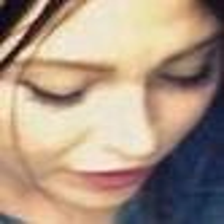

In [ ]:
im = FaceDataset.load_sample('./celebA_ir/celebA_query/001430.jpg')
im = im.resize((RESCALE_SIZE, RESCALE_SIZE))
im


In [ ]:
imt = tt.Compose([tt.ToImage(), tt.ToDtype(torch.float32, scale=True)])(im)
imt.shape

torch.Size([3, 224, 224])

In [ ]:


emb = model(imt.unsqueeze(0).to(DEVICE))
emb.shape

torch.Size([1, 512])

In [ ]:
sample.shape

torch.Size([21, 3, 224, 224])

In [ ]:
def prepare(name):
  im = FaceDataset.load_sample(name)
  im = im.resize((RESCALE_SIZE, RESCALE_SIZE))
  return tt.Compose([tt.ToImage(), tt.ToDtype(torch.float32, scale=True)])(im)


def compute_embeddings(model, images_list, path):
    '''
    compute embeddings from the trained model for list of images.
    params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
    output:
    list: list of model embeddings. Each embedding corresponds to images
            names from images_list
    '''
    # YOUR CODE HERE
    model.eval()
    with torch.no_grad():
      inp = torch.stack([prepare(path + name) for name in images_list])
      loader = DataLoader(inp, batch_size=32)

      ret = []
      for sample in loader:
        ret.append(model(sample.to(DEVICE)).cpu())
    return torch.cat(ret)
    # #   clear_cuda()
    # return ret


In [ ]:
clear_cuda()

In [ ]:
query_embeddings = compute_embeddings(model, query_img_names, '/content/celebA_ir/celebA_query/')
clear_cuda()
distractors_embeddings = compute_embeddings(model, distractors_img_names, '/content/celebA_ir/celebA_distractors/')

In [ ]:
query_embeddings.shape, distractors_embeddings.shape

(torch.Size([1222, 512]), torch.Size([2001, 512]))

In [ ]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list
  '''
  # YOUR CODE HERE
  distances = []
  labels = {l: k for k, v in query_dict.items() for l in v}
  emb_dict = dict.fromkeys(query_dict.keys())
  for l in emb_dict.keys():
    emb_dict[l] = []
  for name, emb in zip(query_img_names, query_embeddings):
    emb_dict[labels[name]].append(emb)
  for label, embs in emb_dict.items():
    for i in range(len(embs)):
      for j in range(i):
        distances.append(distance(embs[i], embs[j]))


  return torch.FloatTensor(distances)

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to different people from query list
  '''
  # YOUR CODE HERE

  distances = []
  labels = {l: k for k, v in query_dict.items() for l in v}
  emb_dict = dict.fromkeys(query_dict.keys(), )
  for l in emb_dict.keys():
    emb_dict[l] = []
  for name, emb in zip(query_img_names, query_embeddings):
    emb_dict[labels[name]].append(emb)




  l_n = len(emb_dict)
  keys = list(emb_dict.keys())
  for i in range(l_n):
    for j in range(i):
      # print(keys[i], keys[j])
      for k in emb_dict[keys[i]]:
        for l in emb_dict[keys[j]]:
          distances.append(distance(k, l))

  return torch.FloatTensor(distances)

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  distances = []
  for q in query_embeddings:
    for d in distractors_embeddings:
      distances.append(distance(q, d))
  return torch.FloatTensor(distances)

In [ ]:

cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)


In [ ]:
(cosine_query_neg)

tensor([0.3378, 0.3625, 0.2646,  ..., 0.4058, 0.3745, 0.2816])

Ячейка ниже проверяет, что код работает верно:

In [ ]:

test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = torch.FloatTensor([
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
])

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = torch.FloatTensor([
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
])

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]

In [ ]:

assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

И, наконец, финальная функция, которая считает IR metric:

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output:
    float: threshold for given fpr
    float: TPR at given FPR
  '''
  false_pair_amount = len(cosine_query_neg) + len(cosine_query_distractors)
  N = int(fpr*false_pair_amount)
  # print(f"{N=}")
  false_pairs = torch.sort(
      torch.cat(
        (cosine_query_neg, cosine_query_distractors)
      )
      , descending=True
    ).values

  # print(false_pairs)
  threshold = false_pairs[N]
  # print(f"{threshold=}")
  en = ((cosine_query_pos > threshold).sum())
  acc = en/len(cosine_query_pos)
  # print(acc)
  # print()
  return threshold, acc


И ячейки для ее проверки:

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [ ]:

true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

А в ячейке ниже вы можете посчитать TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

In [ ]:
res = []
for fpr in [0.5, 0.2, 0.1, 0.05]:
  res.append(compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr))


In [ ]:
for (tr, idm), fpr in zip(res, [0.5, 0.2, 0.1, 0.05]):
  print(f"@fpr = {fpr}:  {idm}")

@fpr = 0.5:  0.8250797986984253
@fpr = 0.2:  0.5538346767425537
@fpr = 0.1:  0.39263635873794556
@fpr = 0.05:  0.2707696557044983


##Оценим модель обученную на CE

In [ ]:
# modelResNet = resnet18(ResNet18_Weights.IMAGENET1K_V1)
modelResNet = torch.load('/content/drive/MyDrive/DLS project/modelResnet.pth')

In [ ]:
modelResNet.eval()
evaluate(modelResNet, test_loader)

0.7293895483016968

In [ ]:
modelResNet.fc = IdBlock()

In [ ]:
clear_cuda()

In [ ]:
query_embeddings = compute_embeddings(modelResNet, query_img_names, '/content/celebA_ir/celebA_query/')
clear_cuda()
distractors_embeddings = compute_embeddings(modelResNet, distractors_img_names, '/content/celebA_ir/celebA_distractors/')

In [ ]:
query_embeddings.shape, distractors_embeddings.shape

(torch.Size([1222, 512]), torch.Size([2001, 512]))

In [ ]:

cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)


In [ ]:
resCE = []
for fpr in [0.5, 0.2, 0.1, 0.05]:
  resCE.append(compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr))


In [ ]:
for (tr, idm), fpr in zip(resCE, [0.5, 0.2, 0.1, 0.05]):
  print(f"@fpr = {fpr}:  {idm}")

@fpr = 0.5:  0.7443788051605225
@fpr = 0.2:  0.478771835565567
@fpr = 0.1:  0.34155288338661194
@fpr = 0.05:  0.24162760376930237


##Сравним качество эмбедингов специализированной и обычной моделями



In [ ]:
for (tr, idm), (trCE, idmCE), fpr in zip(res, resCE, [0.5, 0.2, 0.1, 0.05]):
  print(f"@fpr = {fpr}:  {idm} ||| {idmCE}")

@fpr = 0.5:  0.8250797986984253 ||| 0.7443788051605225
@fpr = 0.2:  0.5538346767425537 ||| 0.478771835565567
@fpr = 0.1:  0.39263635873794556 ||| 0.34155288338661194
@fpr = 0.05:  0.2707696557044983 ||| 0.24162760376930237


##Видим, что модель обученная на специализированный лосс представляет изображения лучше

#Ниже можно не смотреть

#triple loss

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, m = 0, distance = None):
        super().__init__()
        self.m = m
        if distance is None:
            self.distance = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
        else:
            self.distance = distance
    def forward(self, anchor, positive, negative):

        return nn.ReLU()(self.distance(anchor.norm(dim=1), positive.norm(dim=1)) - self.distance(anchor.norm(dim=1), negative.norm(dim=1)) + self.m)

In [ ]:
distance = torch.nn.CosineSimilarity(dim=1, eps=1e-08)


In [ ]:
a = torch.FloatTensor([[0, 1, 1], [0, 1, 1]])
b = torch.FloatTensor([[0, 2, 1], [0, 2, 2]])
distance(a, b)

In [ ]:
model = resnet34(ResNet34_Weights.IMAGENET1K_V1)
model;

In [ ]:
class IdBlock(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return x

In [ ]:
model.fc = IdBlock()
model(sample).shape

In [ ]:
pred = []
k = 0
for i, label in train_loader:
    pred.append(model(i))
    k += 1
    if k == 3:
        break


In [ ]:
len(pred)

In [ ]:
l = TripletLoss()(*pred)
l


# Effnet -- не подошло

In [ ]:


# modelResNet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# modelResNet

modelEff = efficientnet_b3(weights=EfficientNet_B3_Weights)
modelEff

In [ ]:
prev_in = modelEff.classifier[1].in_features
prev_in

In [ ]:
modelEff.classifier =  nn.Sequential(
    nn.Linear(prev_in, 512),
    nn.BatchNorm1d(512),
    nn.SiLU(),
    nn.Linear(512, 500)
)
modelEff.classifier

In [ ]:
modelEff.classifier

In [ ]:
import gc
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
# del unet_model

# del variables
gc.collect()

In [ ]:
def clear_cuda():
  torch.cuda.empty_cache()
  torch.cuda.memory_summary(device=None, abbreviated=False)
  # del unet_model

  # del variables
  gc.collect()

In [ ]:
DEVICE

In [ ]:
a = torch.FloatTensor([1, 0, 0])
b = torch.FloatTensor([0.7, 0.1, 0.2])
nn.CrossEntropyLoss()(a, b)

In [ ]:
effhist = train_w_freezed(modelEff, train_dataset, val_dataset, unfreezed_nm=10, epochs=2)

In [ ]:
effhist1 = train_w_freezed(modelEff, train_dataset, val_dataset, 300)

In [ ]:
effhist3 = train_w_freezed(modelEff, train_dataset, val_dataset, 300, epochs=20)

In [ ]:
torch.save(modelEff, f'effnet')

In [ ]:
evaluate(modelEff, test_loader)

# Resnet -- получилось

In [ ]:
modelResNet1 = resnet18(ResNet18_Weights.IMAGENET1K_V1)
modelResNet1;

In [ ]:
class IdBlock(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return x

In [ ]:
# modelResNet = resnet18(ResNet18_Weights.IMAGENET1K_V1)
modelResNet = torch.load('/content/drive/MyDrive/DLS project/modelResnet.pth')

In [ ]:
modelResNet.eval()
evaluate(modelResNet, test_loader)

In [ ]:
blocks = [i[0] for i in modelResNet.named_children()]
blocks

In [ ]:
modelResNet.fc = nn.Sequential(
    nn.Linear(512, 512)
    , nn.ReLU()
    , nn.Linear(512, 500)
)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    model.train()

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu().numpy() / processed_size
    return val_loss, val_acc


In [ ]:
# opt = torch.optim.Adam(
#         params=[
#             {"params": modelResNet.layer4.parameters(), 'lr': 1e-4},
#             {"params": modelResNet.fc.parameters(), "lr": 1e-4}
#         ])
hist = train(train_loader, val_loader, modelResNet, epochs=10, batch_size=32, opt=opt)

In [ ]:
loss, acc, val_loss, val_acc = zip(*hist)

In [ ]:
plt.figure(figsize=(15, 9))
plt.subplot(2, 1, 1)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.subplot(2, 1, 2)
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
print(count_graded(modelResNet))
modelResNet.eval()
print(evaluate(modelResNet, test_loader))
print(evaluate(modelResNet, train_loader))

In [ ]:
opt1 = freeze_blocks(modelResNet, 4, blocks)

count_graded(modelResNet)

In [ ]:
hist1 = train(train_loader, val_loader, modelResNet, epochs=10, batch_size=32, opt=opt1)

In [ ]:
opt2 = freeze_blocks(modelResNet, 7, blocks)

count_graded(modelResNet)

hist2 = train(train_loader, val_loader, modelResNet, epochs=10, batch_size=32, opt=opt2)

In [ ]:
opt3 = freeze_blocks(modelResNet, 8, blocks)

count_graded(modelResNet)

hist3 = train(train_loader, val_loader, modelResNet, epochs=5, batch_size=32, opt=opt3)

In [ ]:
opt4 = freeze_blocks(modelResNet, 9, blocks)

count_graded(modelResNet)

hist4 = train(train_loader, val_loader, modelResNet, epochs=5, batch_size=32, opt=opt4)

In [ ]:
opt5 = freeze_blocks(modelResNet, 9, blocks)

count_graded(modelResNet)

hist5 = train(train_loader, val_loader, modelResNet, epochs=10, batch_size=32, opt=opt5)

In [ ]:
train_transform = tt.Compose([
    # EfficientNet_B3_Weights.IMAGENET1K_V1.transforms(),
    res_transform(),
    tt.RandomHorizontalFlip(p=0.5),
    # tt.RandomPerspective(distortion_scale=0.5, p=0.3,)
])
test_transform = res_transform()

In [ ]:

train_dataset = FaceDataset(train_data, mode='train', transform=train_transform)
val_dataset = FaceDataset(val_data, mode='val', transform=test_transform)
test_dataset = FaceDataset(test_data, mode='test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
opt6 = freeze_blocks(modelResNet, 9, blocks)

count_graded(modelResNet)

hist6 = train(train_loader, val_loader, modelResNet, epochs=5, batch_size=32, opt=opt6)

In [ ]:
hist7 = train(train_loader, val_loader, modelResNet, epochs=5, batch_size=32, opt=opt6)

In [ ]:
opt6 = freeze_blocks(modelResNet, 9, blocks, lr=1e-5)

count_graded(modelResNet)

hist6 = train(train_loader, val_loader, modelResNet, epochs=5, batch_size=32, opt=opt6)

In [ ]:
opt6 = freeze_blocks(modelResNet, 8, blocks, lr=1e-5)

count_graded(modelResNet)

hist6 = train(train_loader, val_loader, modelResNet, epochs=5, batch_size=32, opt=opt6)

In [ ]:
# modelResNet = torch.load("./modelResnet.pth")

In [ ]:
evaluate(modelResNet, test_loader)

In [ ]:
torch.save(modelResNet, "/content/drive/MyDrive/DLS project/modelResnet.pth")

# Embedings

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
import copy
model_copy = copy.deepcopy(modelResNet)

In [ ]:
model_copy.fc = Identity()

In [ ]:
model_copy(sample.to(DEVICE)).shape

In [ ]:
len(test_dataset), (test_dataset[0][0]).shape

In [ ]:
d = [i.item() for i in torch.randint(500, (20, ))]
d

In [ ]:
samples = []
instances = {l:None for l in d}
labels = []
for i, l in train_dataset:
    if l in d:
        samples.append(i)
        labels.append(l)
        instances[l] = i
samples = torch.stack(samples)
preds = model_copy(samples.to(DEVICE)).detach().cpu()

In [ ]:
labels = torch.Tensor(labels)

In [ ]:
preds.shape, labels.shape

In [ ]:
from sklearn.manifold import TSNE

t = TSNE(2)

In [ ]:
preds = preds.numpy()
labels = labels.numpy()
preds.shape, labels.shape

In [ ]:
k = 365
preds[:k].shape, labels[:k].shape

In [ ]:
pred_clustered = t.fit_transform(preds[:k])

In [ ]:
sc = plt.scatter(pred_clustered[:, 0], pred_clustered[:, 1],c=labels[:k], cmap='Spectral')
plt.colorbar()
plt.show();

In [ ]:
for k, (l, i) in enumerate(instances.items()):
    # print(k)
    plt.subplot(4, 5, k+1)
    show_im(i)

### train arcane

In [ ]:
block_names = []
for i , m in modelResNet1.named_children():
  block_names.append(i)


loss_ = ArcFaceLoss(
                num_classes=500,
                embedding_size=512,
                m=0.2,
                scale=50.0
            )

In [ ]:
modelResNet1 = torch.load("/content/drive/MyDrive/ArcFace3.pth")
count_graded(modelResNet1)
# evaluate(modelResNet1, test_loader)

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=5, blocks=block_names, lr=1e-4)
count_graded(modelResNet1)

In [ ]:
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=5)

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=9, blocks=block_names, lr=1e-3)
count_graded(modelResNet1)

In [ ]:
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=5)

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=9, blocks=block_names, lr=1e-4)
count_graded(modelResNet1)
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=5)

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=10, blocks=block_names, lr=1e-5)
count_graded(modelResNet1)
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=5)

In [ ]:
train_loader, val_loader, test_loader =\
update_loader(base_transform=res_transform(), pre_transform=[tt.RandomHorizontalFlip(p=0.5), tt.RandomPerspective(distortion_scale=0.2, p=0.3,)])

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=10, blocks=block_names, lr=1e-6)
count_graded(modelResNet1)
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=5)

In [ ]:
torch.save(modelResNet1, './drive/MyDrive/ArcFace2.pth')

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=10, blocks=block_names, lr=1e-4)
count_graded(modelResNet1)
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=5)

In [ ]:
train_loader, val_loader, test_loader =\
update_loader(base_transform=res_transform(), pre_transform=[tt.RandomHorizontalFlip(p=0.5),])

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=10, blocks=block_names, lr=1e-4)
count_graded(modelResNet1)
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=5)

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=10, blocks=block_names, lr=1e-3)
count_graded(modelResNet1)
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=5)

In [ ]:
torch.save(modelResNet1, './drive/MyDrive/ArcFace3.pth')

In [ ]:
loss_ = ArcFaceLoss(
                num_classes=500,
                embedding_size=512,
                m=0.02,
                scale=30.0
            ).to(DEVICE)

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=10, blocks=block_names, lr=1e-3)
count_graded(modelResNet1)
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=5)

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=10, blocks=block_names, lr=1e-4)
count_graded(modelResNet1)
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=5)

In [ ]:
# train_transform = tt.Compose([
#     resTransform(),
#     tt.RandomHorizontalFlip(p=0.5),
# ])

train_transform = tt.Compose([
    # EfficientNet_B3_Weights.IMAGENET1K_V1.transforms(),
    res_transform(),
    tt.RandomHorizontalFlip(p=0.5),
    tt.RandomPerspective(distortion_scale=0.2, p=0.3,)
])
test_transform = res_transform()

In [ ]:
train_transform = tt.Compose([
    # EfficientNet_B3_Weights.IMAGENET1K_V1.transforms(),
    res_transform(),
    tt.RandomHorizontalFlip(p=0.5),
    tt.RandomPerspective(distortion_scale=0.2, p=0.3,)
])
test_transform = res_transform()

train_dataset = FaceDataset(train_data, mode='train', transform=train_transform)
val_dataset = FaceDataset(val_data, mode='val', transform=test_transform)
test_dataset = FaceDataset(test_data, mode='test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
len(train_data), len(val_data), len(test_data)


In [ ]:
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=10)

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=5, blocks=block_names, lr=1e-4)
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=10)

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=5, blocks=block_names, lr=1e-3)
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=5)

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=5, blocks=block_names, lr=1e-5)
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=10)

In [ ]:
torch.save(modelResNet1, './drive/MyDrive/ArcFace1.pth')

In [ ]:
opt11 = freeze_blocks(modelResNet1, num=8, blocks=block_names, lr=1e-5)
count_graded(modelResNet1)
# hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
#               opt=opt11, criterion=loss_, epochs=10)

In [ ]:
hist_arc = train_arcane(model=modelResNet1, batch_size=30, train_loader=train_loader, val_loader=val_loader,
              opt=opt11, criterion=loss_, epochs=10)

In [ ]:
for i in train_loader:
  print(f"{i=}")
  break

In [ ]:
labels = torch.randint(5, size=(32,))
labels

In [ ]:
print(f"{inp.shape=}")
# logits = ArcFaceLossFC(in_=512, out_=5)(inp)
# probs = ArcFaceLossSoftMax(m=0., s=1)(logits)
losss = ArcFaceLossEntropy(3)

In [ ]:
probs = torch.FloatTensor([[1, 0, 0], [0, 1, 0]])
probs2 = torch.FloatTensor([[0.5, 0.5, 0], [0, 1, 0]])

labels = torch.LongTensor([0, 1, 0, 2])

In [ ]:
print(losss(probs, labels))
print(losss(probs2, labels))

In [ ]:
probs

In [ ]:
oh = F.one_hot(labels)
oh

In [ ]:
oh*probs

In [ ]:
inp.shape, logits.shape

In [ ]:
probs.sum(dim=1)

In [ ]:
A = torch.Tensor([[1, 2, 3, 10], [4, 5, 6, 20], [7, 8, 9, 100]])
print(A.shape)
sA = A.sum(dim=1)
print(sA)
iiii = sA[:, None]-A
print(iiii)
print(iiii.shape)

In [ ]:
inst = test_dataset[-7]
same = 0
other = 0
for i in train_dataset:
    if i[1] == inst[1]:
        same = i
        break
    else:
        other = i
k = 1
for i, l in (same, inst, other):
    print(l)
    plt.subplot(1, 3, k)
    k += 1
    show_im(i)
# show_im(same[0])

In [ ]:
inst_pred = torch.sigmoid(modelResNet(inst[0].unsqueeze(0).to(DEVICE)).detach().to('cpu').squeeze()).numpy()
same_pred = torch.sigmoid(modelResNet(same[0].unsqueeze(0).to(DEVICE)).detach().to('cpu').squeeze()).numpy()
other_pred = torch.sigmoid(modelResNet(other[0].unsqueeze(0).to(DEVICE)).detach().to('cpu').squeeze()).numpy()

In [ ]:
k = 0
for i in (inst_pred, same_pred, other_pred):
    k += 1
    plt.subplot(3, 1, k)
    print(i.argmax())
    plt.scatter(np.linspace(0, 499, 500), i)

In [ ]:
evaluate(modelResNet, train_loader)

In [ ]:
for name, module in modelResNet.named_children():
    for param in module.parameters():
        param.requires_grad = True
    print(name)
print()
count_graded(modelResNet)

In [ ]:
num = (len(list(modelResNet.fc.parameters())))
opt = torch.optim.Adam(
        params=[
            {"params": modelResNet.fc.parameters(), 'lr': 1e-4},
            {"params": list(modelResNet.parameters())[:-num], "lr": 1e-5,}
        ])

hist_full = train(train_loader, val_loader, modelResNet, epochs=10, batch_size=32, opt=opt)

In [ ]:
hist_full2 = train(train_loader, val_loader, modelResNet, epochs=10, batch_size=32, opt=opt)

In [ ]:
evaluate(modelResNet, test_loader)

In [ ]:
torch.save(modelResNet, "firstresnet")

In [ ]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

# efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
model = efficientnet_b3(weights="DEFAULT")

In [ ]:
freeze_layers(model, 10);

In [ ]:
print(count_graded(modelResNet))
# print(freeze_layers(modelResNet, 10))
# print(count_graded(modelResNet))


In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
effnet = models.efficientnet_b3(weights='DEFAULT')

In [ ]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

In [ ]:
for i, k in efficientnet.named_children():
    print(i)

In [ ]:
efficientnet

In [ ]:
def train_w_freezed(model, train_datasset=train_dataset, val_dataset=val_dataset, unfreezed_nm=1, lr_classifier=1e-4, lr_feature=1e-4, epochs=5, batch_size=64):
  train_w_freezed.called_times += 1
  model, optimizer = freeze_layers(model, numm = unfreezed_nm, lr1=lr_classifier, lr2=lr_feature)
  history = train(train_dataset, val_dataset, model=model, epochs=epochs, batch_size=batch_size, opt=optimizer)
  torch.save(model, f'/content/gdrive/MyDrive/efn{train_w_freezed.called_times}.pth')
  return history

train_w_freezed.called_times = 0


In [ ]:
hist = train_w_freezed(modelResNet, epochs=2 )